In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from tqdm import tqdm_notebook
import cv2
from PIL import Image

import keras
from keras.layers.convolutional import Conv2DTranspose
from keras.layers.merge import concatenate
from keras.layers import UpSampling2D, Conv2D, Activation, Input, Dropout, MaxPooling2D
from keras import Model
from keras import backend as K
from keras.layers.core import Lambda
from skimage.morphology import binary_opening, disk, label
from skimage.segmentation import mark_boundaries
from keras.models import load_model

from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 10149439429556184631,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 6950027264
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 9096834187160852520
 physical_device_desc: "device: 0, name: NVIDIA GeForce GTX 1070 with Max-Q Design, pci bus id: 0000:01:00.0, compute capability: 6.1"]

In [2]:
tr = pd.read_excel(r'C:\Users\user\Cracks_Detector\SyntheticMasks.xlsx')

In [3]:
df_train = tr.copy()

In [4]:
def multi_rle_encode(img, **kwargs):
    labels = label(img)
    if img.ndim > 2:
        return [rle_encode(np.sum(labels==k, axis=2), kwargs) for k in np.unique(labels[labels>0])]
    else:
        return [rle_encode(labels==k, *kwargs) for k in np.unique(labels[labels>0])]

def rle_encode(img, min_max_threshold=1e-3, max_mean_threshold=None):
    if np.max(img) < min_max_threshold:
        return '' 
    if max_mean_threshold and np.mean(img) > max_mean_threshold:
        return '' 
    pixels = img.T.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

def rle_decode(mask_rle, shape=(32, 32)):
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape).T

def masks_as_image(in_mask_list):
    all_masks = np.zeros((32, 32), dtype = np.uint8)
    for mask in in_mask_list:
        if isinstance(mask, str):
            all_masks |= rle_decode(mask)
    return all_masks

def masks_as_color(in_mask_list):
    all_masks = np.zeros((32, 1024), dtype = np.float)
    scale = lambda x: (len(in_mask_list)+x+1) / (len(in_mask_list)*2) 
    for i,mask in enumerate(in_mask_list):
        if isinstance(mask, str):
            all_masks[:,:] += scale(i) * rle_decode(mask)
    return all_masks

In [5]:
from sklearn.model_selection import train_test_split
train_df, valid_df = train_test_split(df_train, 
                 test_size = 0.01)
print(train_df.shape[0], 'training masks')
print(valid_df.shape[0], 'validation masks')

50891 training masks
515 validation masks


In [6]:
def keras_generator(in_df, batch_size):
    while True:
        x_batch = []
        y_batch = []
        
        for i in range(batch_size):  
            fn = in_df['ImageId'].iloc[i]
   
            img = cv2.imread(r'C:\Users\user\Cracks_Detector\SyntheticTrain\\' + fn )
            img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            mask = tr.query('ImageId=="' + fn + '"')['EncodedPixels']

            rle = masks_as_image(mask)
            img = cv2.resize(img, (32, 32))
    
            x_batch += [img]
            y_batch += [rle]
                                    
        x_batch = np.array(x_batch)
        y_batch = np.array(y_batch).swapaxes(1,2)

        yield x_batch, np.expand_dims(y_batch, -1)

In [7]:
for x_valid, y_valid in keras_generator(valid_df, len(valid_df)):
    break
print(x_valid.shape, y_valid.shape)

(515, 32, 32) (515, 32, 32, 1)


In [8]:
inputs = Input((32, 32, 1))
s = Lambda(lambda x_train: x_train / 255) (inputs)

c1 = Conv2D(16, (3, 3), activation='elu', padding='same') (s)
c1 = Dropout(0.1) (c1)
c1 = Conv2D(16, (3, 3), activation='elu', padding='same') (c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(32, (3, 3), activation='elu', padding='same') (p1)
c2 = Dropout(0.1) (c2)
c2 = Conv2D(32, (3, 3), activation='elu', padding='same') (c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(64, (3, 3), activation='elu', padding='same') (p2)
c3 = Dropout(0.2) (c3)
c3 = Conv2D(64, (3, 3), activation='elu', padding='same') (c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(128, (3, 3), activation='elu', padding='same') (p3)
c4 = Dropout(0.2) (c4)
c4 = Conv2D(128, (3, 3), activation='elu', padding='same') (c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

c5 = Conv2D(256, (3, 3), activation='elu', padding='same') (p4)
c5 = Dropout(0.3) (c5)
c5 = Conv2D(256, (3, 3), activation='elu', padding='same') (c5)

u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c5)
u6 = concatenate([u6, c4])
c6 = Conv2D(128, (3, 3), activation='elu', padding='same') (u6)
c6 = Dropout(0.2) (c6)
c6 = Conv2D(128, (3, 3), activation='elu', padding='same') (c6)

u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(64, (3, 3), activation='elu', padding='same') (u7)
c7 = Dropout(0.2) (c7)
c7 = Conv2D(64, (3, 3), activation='elu', padding='same') (c7)

u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(32, (3, 3), activation='elu', padding='same') (u8)
c8 = Dropout(0.1) (c8)
c8 = Conv2D(32, (3, 3), activation='elu', padding='same') (c8)

u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(16, (3, 3), activation='elu', padding='same') (u9)
c9 = Dropout(0.1) (c9)
c9 = Conv2D(16, (3, 3), activation='elu', padding='same') (c9)

outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

model = Model(inputs=[inputs], outputs=[outputs])
callback = keras.callbacks.EarlyStopping(monitor='val_dice_coef', patience=20)

def dice_coef(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return -(2. * intersection + smooth) \
            / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[dice_coef])

In [9]:
results = [model.fit_generator(keras_generator(train_df, 3000), 
                              steps_per_epoch=25,
                              epochs=20000,
                              callbacks = [callback],
                              validation_data=(x_valid, y_valid))]

c:\users\user\appdata\local\programs\python\python39\lib\site-packages\keras\engine\training.py:1915: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20000
25/25 [==============================] - 192s 7s/step - loss: 0.3501 - dice_coef: -0.0531 - val_loss: 0.1679 - val_dice_coef: -0.0424
Epoch 2/20000
25/25 [==============================] - 166s 7s/step - loss: 0.1689 - dice_coef: -0.0501 - val_loss: 0.1510 - val_dice_coef: -0.0612
Epoch 3/20000
25/25 [==============================] - 168s 7s/step - loss: 0.1500 - dice_coef: -0.0894 - val_loss: 0.1100 - val_dice_coef: -0.2229
Epoch 4/20000
25/25 [==============================] - 167s 7s/step - loss: 0.1035 - dice_coef: -0.3218 - val_loss: 0.0764 - val_dice_coef: -0.4561
Epoch 5/20000
25/25 [==============================] - 167s 7s/step - loss: 0.0771 - dice_coef: -0.4840 - val_loss: 0.0635 - val_dice_coef: -0.5480
Epoch 6/20000
25/25 [==============================] - 169s 7s/step - loss: 0.0666 - dice_coef: -0.5497 - val_loss: 0.0592 - val_dice_coef: -0.5874
Epoch 7/20000
25/25 [==============================] - 168s 7s/step - loss: 0.0597 - dice_coef: -0.5921 - val_lo

In [10]:
model.save('Cracks32.h5')

In [11]:
#tr = pd.read_excel(r'C:\Users\user\Documents\Disser\Книга2.xlsx')

In [12]:
#df_train = tr.copy()

In [13]:
#from sklearn.model_selection import train_test_split
#train_df, valid_df = train_test_split(df_train, 
           #      test_size = 0.1)
#print(train_df.shape[0], 'training masks')
#print(valid_df.shape[0], 'validation masks')

In [14]:
#print(train_df)

In [15]:
#for x_train, y_train in keras_generator(train_df, len(train_df)):
#    break

In [16]:
#for x_valid, y_valid in keras_generator(valid_df, len(valid_df)): 
#    break

In [17]:
#modelPhase = Model(inputs=[inputs], outputs=[outputs])
#modelPhase.compile(optimizer='adam', loss='binary_crossentropy', metrics=[dice_coef])

#results = [modelPhase.fit_generator(keras_generator(train_df, 90), 
  #                            steps_per_epoch=25,
 #                             epochs=20000,
  #                            callbacks = [callback],
 #                             validation_data=(x_valid, y_valid))]

In [18]:
#model.save('Phase32.h5')

In [19]:
def dice_coef(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return -(2. * intersection + smooth) \
            / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

In [25]:
from keras.models import load_model
GPR_RGB = cv2.imread(r'C:\Users\user\Cracks_Detector\Radarograms\402.png')
GPR = cv2.cvtColor(GPR_RGB, cv2.COLOR_BGR2GRAY)
    
modelCrack = load_model(r'C:\Users\user\Cracks_Detector\Cracks32.h5', custom_objects={'dice_coef': dice_coef})
#modelPhase = load_model(r'C:\Users\user\Phase32.h5', custom_objects={'dice_coef': dice_coef})

maskCracks = np.zeros(GPR.shape)
#maskPhase = np.zeros(GPR.shape)
count_mask = np.zeros(GPR.shape)

for i in range(0, GPR.shape[0] - 31, 4):
    for j in range(0, GPR.shape[1] - 31, 4):
        cell = np.array([GPR[i:i+32,j:j+32]])
        predCrack = modelCrack.predict(cell)[0].reshape(32,32)
        #predPhase = modelPhase.predict(cell)[0].reshape(16,16)
        maskCracks[i:i+32,j:j+32] += predCrack
        #maskPhase[i:i+16,j:j+16] += predPhase
        count_mask[i:i+32,j:j+32] += 1
                
maskCracks = np.divide(maskCracks,count_mask)
#maskPhase = np.divide(maskPhase,count_mask)

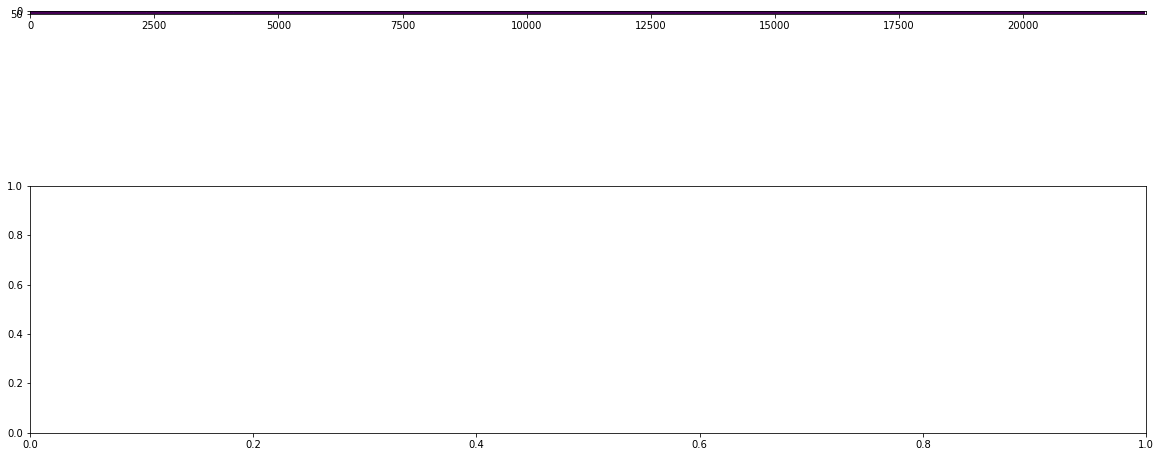

In [21]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize = (20, 10))
ax1.imshow(maskCracks)
#ax2.imshow(maskPhase)

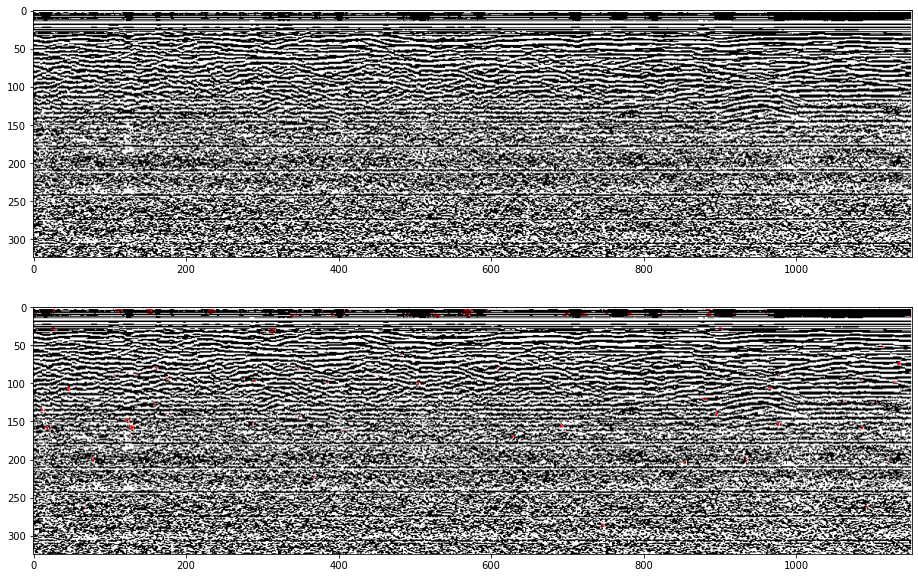

In [26]:
GPR_RGB = cv2.imread(r'C:\Users\user\Cracks_Detector\Radarograms\402.png')
GPR_RGB_1 = cv2.imread(r'C:\Users\user\Cracks_Detector\Radarograms\402.png')
for i in range(GPR_RGB.shape[0] - 1):
    for j in range(GPR_RGB.shape[1] - 1):
        #if maskPhase[i,j] > 0.2:
            #    GPR_RGB[i, j] = [186,85,211]
        if GPR_RGB[i, j, 0] == 255 and GPR_RGB[i, j, 1] == 255 and GPR_RGB[i, j, 2] == 255:
                if maskCracks[i,j] > 0.1:
                #if maskCracks[i,j - 1] < 0.25 and maskCracks[i - 1,j] < 0.25 and maskCracks[i - 1,j - 1] < 0.25 and maskCracks[i + 1,j] < 0.25 and maskCracks[i,j + 1] < 0.2 and maskCracks[i + 1,j + 1] < 0.2 and maskCracks[i + 1,j - 1] < 0.2 and maskCracks[i - 1,j + 1] < 0.2:
                    GPR_RGB[i, j] = [255,0,0]
                #else:
                #   GPR_RGB[i, j] = [255,0,0]

fig, (ax1, ax2) = plt.subplots(2, 1, figsize = (20, 10))
ax1.imshow(GPR, cmap="gray")             
ax2.imshow(GPR_RGB)

im = Image.fromarray(GPR_RGB)
im.save('radmask.png')
im = Image.fromarray(GPR_RGB_1)
im.save('radmask_1.png')


AttributeError: 'NoneType' object has no attribute 'shape'

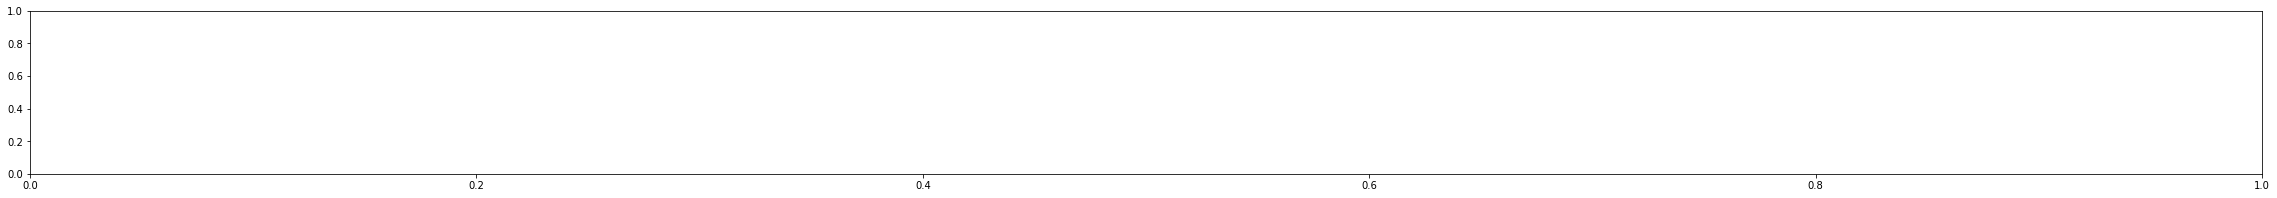

In [23]:
fig, (ax1) = plt.subplots(1, 1, figsize = (40, 3))
GPR_RGB = cv2.imread(r'C:\Users\semas\radmask.png')

cracksCount = np.zeros(maskCracks.shape[1])
for j in range(GPR_RGB.shape[1]):
    for i in range(GPR_RGB.shape[0]):
        if GPR_RGB[i,j,0] == 0 and GPR_RGB[i,j,1] == 0 and GPR_RGB[i,j,2] == 255:
            cracksCount[j] += 1
ax1.plot(cracksCount, color = 'red')

plt.savefig('графики.png')

# 